## Accquire

**imports**

In [1]:
# data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# data
import requests

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# spliting the data
from sklearn.model_selection import TimeSeriesSplit
from math import ceil

# system manipulation
import sys
sys.path.append("./util_")
# import acquire_
import prepare_

# other
import warnings
warnings.filterwarnings("ignore")

**Get data**

Data from FDIC on [data.gov](https://catalog.data.gov/dataset/fdic-failed-bank-list)

In [2]:
# get data with request link
responce = requests.get("https://catalog.data.gov/harvest/object/cb22fea9-0c90-43e9-94bf-903eacd37c92")

# locate csv url
data_url = responce.json()["distribution"][0]["downloadURL"]

In [3]:
# Try different encodings one by one until one works without an error
encodings_to_try = ['utf-8', 'ISO-8859-1', 'utf-16']

for encoding in encodings_to_try:
    try:
        # Read the CSV file from the URL with the specified encoding
        bank = pd.read_csv(data_url, encoding=encoding)
        # If no error occurs, break the loop and continue with further processing
        break
    except UnicodeDecodeError:
        # If an error occurs with the current encoding, try the next one
        continue

In [4]:
bank

,Bank Name,City,State,Cert,Acquiring Institution,Closing Date,Fund
0,Heartland Tri-State Bank,Elkhart,KS,25851,"Dream First Bank, N.A.",28-Jul-23,10544
1,First Republic Bank,San Francisco,CA,59017,"JPMorgan Chase Bank, N.A.",1-May-23,10543
2,Signature Bank,New York,NY,57053,"Flagstar Bank, N.A.",12-Mar-23,10540
3,Silicon Valley Bank,Santa Clara,CA,24735,FirstCitizens Bank & Trust Company,10-Mar-23,10539
4,Almena State Bank,Almena,KS,15426,Equity Bank,23-Oct-20,10538
...,...,...,...,...,...,...,...
562,"Superior Bank, FSB",Hinsdale,IL,32646,"Superior Federal, FSB",27-Jul-01,6004
563,Malta National Bank,Malta,OH,6629,North Valley Bank,3-May-01,4648
564,First Alliance Bank & Trust Co.,Manchester,NH,34264,Southern New Hampshire Bank & Trust,2-Feb-01,4647
565,National State Bank of Metropolis,Metropolis,IL,3815,Banterra Bank of Marion,14-Dec-00,4646


**Understand data**

In [5]:
# look at the shape of the data
bank.shape

(567, 7)

In [6]:
# what columns are in the data
bank.columns

Index(['Bank Name ', 'City ', 'State ', 'Cert ', 'Acquiring Institution ',
       'Closing Date ', 'Fund'],
      dtype='object')

In [7]:
# count all the null values
bank.isna().sum().values.sum() / len(bank)

0.0

In [8]:
# look at the bak infromation
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Bank Name               567 non-null    object
 1   City                    567 non-null    object
 2   State                   567 non-null    object
 3   Cert                    567 non-null    int64 
 4   Acquiring Institution   567 non-null    object
 5   Closing Date            567 non-null    object
 6   Fund                    567 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 31.1+ KB


In [9]:
# look at the distribution of the data
bank.describe()

,Cert,Fund
count,567.000000,567.000000
mean,31701.056437,10040.435626
std,16464.762790,1112.193881
min,91.000000,4645.000000
25%,20159.000000,10117.500000
50%,32165.000000,10259.000000
75%,35375.500000,10400.500000
max,59017.000000,10544.000000


In [10]:
# count of numeric columns and object columns
numerics_count = len(bank.select_dtypes("number").columns)
objects_count = len(bank.select_dtypes("object").columns)

print("Numeric col count:", numerics_count)
print("object col count:", objects_count)

Numeric col count: 2
object col count: 5


Take aways:

- I have 566 rows and 7 columns
- 2 numeric columns and 5 string columns
- 0 null count
- I also have descriptive statistics of my data

## Prepare

**Rename columns**

In [11]:
# make the columsn lower case
# replace spaces
bank.columns = bank.columns.str.lower().str.strip().str.replace("†","").str.replace(" ","_")
bank.head(1)

,bank_name,city,state,cert,acquiring_institution,closing_date,fund
0,Heartland Tri-State Bank,Elkhart,KS,25851,"Dream First Bank, N.A.",28-Jul-23,10544


**Convert data types**

In [12]:
# view datatypes
bank.dtypes

bank_name                object
city                     object
state                    object
cert                      int64
acquiring_institution    object
closing_date             object
fund                      int64
dtype: object

In [13]:
# count the unique value counts in each column
for i in bank.columns:
    print("_" * 20, i.upper())
    print(bank[i].value_counts().value_counts())

____________________ BANK_NAME
1    535
2     10
3      4
Name: bank_name, dtype: int64
____________________ CITY
1     360
2      53
3      12
4       6
20      1
10      1
6       1
5       1
Name: city, dtype: int64
____________________ STATE
1     5
2     5
4     4
7     4
10    4
3     3
16    2
6     2
12    2
8     2
9     1
5     1
93    1
76    1
13    1
14    1
19    1
23    1
43    1
69    1
11    1
Name: state, dtype: int64
____________________ CERT
1    567
Name: cert, dtype: int64
____________________ ACQUIRING_INSTITUTION
1     202
2      45
3      22
4      12
5       7
6       4
7       3
31      1
12      1
11      1
10      1
9       1
8       1
Name: acquiring_institution, dtype: int64
____________________ CLOSING_DATE
1    147
2     37
3     29
4     20
5     11
7      9
6      6
8      2
9      1
Name: closing_date, dtype: int64
____________________ FUND
1    567
Name: fund, dtype: int64


In [14]:
# covert closing_date data type to date time
bank.closing_date = bank.closing_date.astype("datetime64")

**Drop columns**

In [15]:
# remove redundent columns
bank = bank.drop(columns=["cert"])

**Drop duplicates**

In [16]:
# remove duplicated rows
bank = bank.drop_duplicates()

In [17]:
# find dublicated bank names
b_name_values = bank.bank_name.value_counts().sort_values()

# Filter the DataFrame to get only rows with duplicated bank names
bank[bank.bank_name.isin(b_name_values.index[b_name_values > 1])].sort_values("bank_name")

,bank_name,city,state,acquiring_institution,closing_date,fund
479,Citizens National Bank,Macomb,IL,Morton Community Bank,2009-05-22,10063
402,Citizens National Bank,Teague,TX,U.S. Bank N.A.,2009-10-30,10141
290,First National Bank,Savannah,GA,"The Savannah Bank, N.A.",2010-06-25,10251
296,First National Bank,Rosedale,MS,The Jefferson Bank,2010-06-04,10247
139,First State Bank,Cranford,NJ,Northfield Bank,2011-10-14,10403
445,First State Bank,Sarasota,FL,"Stearns Bank, N.A.",2009-08-07,10098
426,First State Bank,Flagstaff,AZ,Sunwest Bank,2009-09-04,10114
71,Frontier Bank,LaGrange,GA,HeritageBank of the South,2013-03-08,10471
311,Frontier Bank,Everett,WA,"Union Bank, N.A.",2010-04-30,10228
256,Horizon Bank,Bradenton,FL,Bank of the Ozarks,2010-09-10,10286


**Set index**

In [18]:
# set the date to be the indexinf column
bank = bank.set_index("closing_date")
bank.head(1)

,bank_name,city,state,acquiring_institution,fund
closing_date,,,,,
2023-07-28,Heartland Tri-State Bank,Elkhart,KS,"Dream First Bank, N.A.",10544


**Plot distributions**

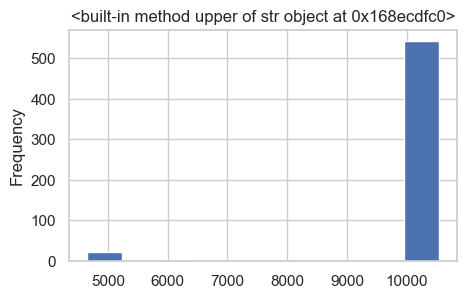

In [19]:
#  Visualize the distribution
plt.figure(figsize=(5,3))
bank.fund.plot(kind="hist")
plt.title("bank fund distribution".upper)

# save visual
prepare_.save_visuals_(plt.gcf(), viz_name= "fund_distribution")

plt.show()

**Sort datetime index**

In [20]:
# reset the index in order
bank = bank.sort_index()
bank.head()

,bank_name,city,state,acquiring_institution,fund
closing_date,,,,,
2000-10-13,Bank of Honolulu,Honolulu,HI,Bank of the Orient,4645
2000-12-14,National State Bank of Metropolis,Metropolis,IL,Banterra Bank of Marion,4646
2001-02-02,First Alliance Bank & Trust Co.,Manchester,NH,Southern New Hampshire Bank & Trust,4647
2001-05-03,Malta National Bank,Malta,OH,North Valley Bank,4648
2001-07-27,"Superior Bank, FSB",Hinsdale,IL,"Superior Federal, FSB",6004


**Frequency of time**

In [21]:
# occurrences of each date
bank.index.value_counts()

2009-10-30    9
2010-08-20    8
2010-04-16    8
2010-04-30    7
2009-07-24    7
             ..
2010-04-09    1
2010-05-21    1
2010-06-11    1
2010-06-18    1
2023-07-28    1
Name: closing_date, Length: 262, dtype: int64

In [22]:
# occurrences of each dates occurrence
bank.index.value_counts().value_counts()

1    147
2     37
3     29
4     20
5     11
7      9
6      6
8      2
9      1
Name: closing_date, dtype: int64

**Check for gaps in time**

In [23]:
# earliest date
min_date = bank.index.min()
min_date

Timestamp('2000-10-13 00:00:00')

In [24]:
# latest date
max_date = bank.index.max()
max_date

Timestamp('2023-07-28 00:00:00')

In [25]:
#see how many unique days we actually have
bank.shape[0], bank.index.nunique()

# here I see that there is a big time gap

(567, 262)

**Find the missing dates**

In [26]:
#establish all the expected dates in our range
expected_date_range = pd.date_range(min_date, max_date, freq="m")
expected_date_range

DatetimeIndex(['2000-10-31', '2000-11-30', '2000-12-31', '2001-01-31',
               '2001-02-28', '2001-03-31', '2001-04-30', '2001-05-31',
               '2001-06-30', '2001-07-31',
               ...
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30'],
              dtype='datetime64[ns]', length=273, freq='M')

In [27]:
# now which dates are missing
len(expected_date_range.difference(bank.index))

264

**Create my time target**

The time target is simply the difference in day between one closing date and the next.

In [28]:
# The date below is the next date in line within the dataset
date_below = bank.index[1:]

# Calculate the time difference between each element in date_below and bank.index
time_difference = date_below - bank.index[:-1]

# get the days
days_diff = time_difference.days
days_diff

Int64Index([ 62,  50,  90,  85,  42, 126,   7,  14,   6,  22,
            ...
              0,   7, 105,  49, 196,   7, 868,   2,  50,  88],
           dtype='int64', name='closing_date', length=566)

In [29]:
# last_close_date is the day of the last failed bank
last_day =(bank.index[-1] - bank.index[-1]).days

# add last day to the list of days diff
days_diff = np.append(days_diff,last_day)

# add changes to the dataframe
bank["days_diff"] = days_diff

In [30]:
bank.tail(1)

,bank_name,city,state,acquiring_institution,fund,days_diff
closing_date,,,,,,
2023-07-28,Heartland Tri-State Bank,Elkhart,KS,"Dream First Bank, N.A.",10544,0


**Plot difference in days over time**

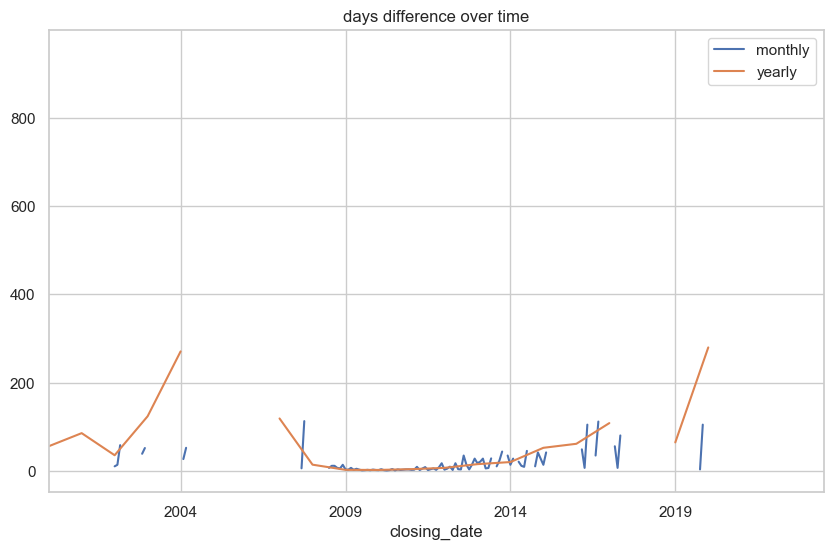

In [31]:
plt.figure(figsize=(10,6))

# bank.resample('D').mean().days_diff.plot(label='daily')
# bank.resample('W').mean().days_diff.plot(label='weekly')
bank.resample('M').mean().days_diff.plot(label='monthly')
bank.resample('Y').mean().days_diff.plot(label='yearly')
plt.title('days difference over time')
plt.legend()

# save visual
prepare_.save_visuals_(plt.gcf(), viz_name= "days_difference_over_time")
plt.show()


**create a year, month and day column**

In [32]:
# create a year, month, day column from the index
bank["year"] = bank.index.year
bank["month"] = bank.index.month_name()
bank["day"] = bank.index.day_name()

bank["month_number"] = bank.index.month
bank["weekday_number"] = bank.index.weekday

bank.head(1)

,bank_name,city,state,acquiring_institution,fund,days_diff,year,month,day,month_number,weekday_number
closing_date,,,,,,,,,,,
2000-10-13,Bank of Honolulu,Honolulu,HI,Bank of the Orient,4645,62,2000,October,Friday,10,4


**Split data**

Use percentage methode for spliting because there is no seasonality in the failing banks.

In [33]:
# data set sizes
train_size = 0.7
validate_size = 0.2
test_size = 0.1

# spliting index
train_split_index = ceil(bank.shape[0] * train_size)
validate_split_index = train_split_index + ceil(bank.shape[0] * validate_size)

train_split_index,validate_split_index

(397, 511)

In [34]:
train = bank.iloc[:train_split_index]
validate = bank.iloc[train_split_index:validate_split_index] 
test = bank.iloc[validate_split_index:]

train.shape, validate.shape, test.shape

((397, 11), (114, 11), (56, 11))

In [35]:
# save the split data
prepare_.save_split_data_(cleaned_data=bank, train=train, validate=validate, test=test)

'Four data sets saved as .csv'

**Actions taken and take aways**

- Rename columns.
- Convert data types (closing_date).
- Drop columns (cert).
- Drop duplicates (0 count), some bank names are duplicated but this is because:
    - Branches at different locations where aquired by different bank institutions.
    - different bank locations closed on different dates.
    - count of the duplicated bank names is 14 (they all stay in the data).
- Plot distibution.
    - Not normal distribution.
- Set and sort date index.
- Check for gaps in time (7975 days missing).
    - Erliest time (oct 13, 2000).
    - Latest time (May 1, 2023).
- Create a time target.
    - The time target is the difference in day between one closing date to the next.
- Use percentage based spliting.
    - Because there is no seasonality in the failing banks.